# Cubic splines

The file `cubic_splines.pdf` presents some notes about the cubic splines method.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

#used for inserting images
from IPython.display import Image as img

In [2]:
def spline3(x, f):
    '''
    Return the b, c, and d coefficients of the
    cubic spline of each interval.
    
    input
    x: numpy array - coordinates x of the data.
    f: numpy array - data values at the coordinates x.
    
    output
    D: numpy array - b coefficients at each point x.
    c: numpy array - c coefficients at the interval.
    d: numpy array - d coefficients at the interval.    
    '''
    
    L = f.size
    
    g = 3.*np.hstack(((f[1] - f[0]), (f[2:] - f[:L-2]), (f[-1] - f[-2])))

    indices = np.arange(L)
    A = np.zeros((L,L))
    A[indices[1:L-1],indices[1:L-1]] = 4.
    A[0,0] = 2.
    A[L-1,L-1] = 2.
    A[indices[:L-1],indices[1:]] = 1.
    A[indices[1:],indices[:L-1]] = 1.
    
    D = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, g))
    
    c = 3.*(f[1:] - f[:L-1]) - 2.*D[:L-1] - D[1:]
    d = 2.*(f[:L-1] - f[1:]) + D[:L-1] + D[1:]
    
    return D, c, d

In [3]:
def define_t(x, x0):
    '''
    Define the variables t at each interval.
    
    input
    x: numpy array - coordinates x of the data.
    x0: numpy array - coordinates x of the interpolating points.
    '''
    diffx = x[1:] - x[:-1]

    t = []
    t_size = []
    t_intervals = []
    i0 = 0
    for i, (dxi, xi, xi_plus) in enumerate(zip(diffx, x[:-1], x[1:])):
        mask = (x0[i0:] >= xi) & (x0[i0:] < xi_plus)
        ti = x0[i0:][mask]
        i0 += ti.size
        t_size.append(ti.size)
        if ti.size > 0:
            t.append((ti - xi)/dxi)
            t_intervals.append(i)

    t_size = np.array(t_size, dtype=int)
    t_intervals = np.array(t_intervals, dtype=int)
    
    return t, t_size, t_intervals

In [4]:
def spline3_interpolate(a,b,c,d,x,x0):
    '''
    Return the inteprolated data at the points x0.
    
    input
    a: numpy array - a coefficients of each interval.
    b: numpy array - b coefficients of each interval.
    c: numpy array - c coefficients of each interval.
    d: numpy array - d coefficients of each interval.
    x: numpy array - coordinates x of the data.
    x0: numpy array - coordinates x of the interpolating points.
    
    output:
    y0: numpy array - interpolated data.
    '''
    
    y0 = []
    
    t, t_size, t_intervals = define_t(x, x0)
    
    for (ti, ti_size, ai, bi, ci, di) in zip(t, t_size[t_intervals], \
                                            a[t_intervals], b[t_intervals], \
                                            c[t_intervals],d[t_intervals]):

        y0i = np.zeros(ti_size) + ai
    
        e = ti.copy()
        y0i += bi*e
            
        e = e*ti
        y0i += ci*e
        
        e = e*ti
        y0i += di*e
        
        y0.append(y0i)
        
    y0 = np.hstack(y0)

    return y0

### Input data

In [5]:
L = 15

xmax = 14.
xmin = 0.

dx = (xmax - xmin)/(L-1)

x = np.linspace(xmin, xmax, L) + (np.random.rand(L) - 0.5)*3.*dx
x = np.sort(x)

xmax = np.max(x)
xmin = np.min(x)

# data
y = np.sin(2.*np.pi*x/10.)

### Interpolating points

In [6]:
x0min = np.ceil(xmin)
x0max = np.floor(xmax)
nx0 = 10

x0 = np.linspace(x0min,x0max,nx0) # interpolating points
y0 = np.sin(2.*np.pi*x0/10.)      # true values of the original function at the interpolation points

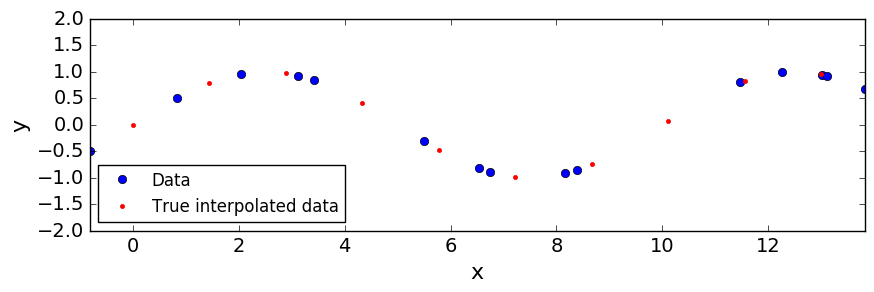

In [7]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.axis('scaled')
plt.plot(x, y, 'bo', label='Data')
plt.plot(x0, y0, 'r.', label='True interpolated data')
plt.xlim(np.min([np.min(x0),np.min(x)]), np.max([np.max(x0),np.max(x)]))
plt.ylim(-2., 2.)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', numpoints=1, fontsize=12)
plt.show()

### Testing the function `define_t`

In [8]:
t, t_size, t_intervals = define_t(x, x0)

In [9]:
t_intervals

array([ 0,  1,  2,  4,  5,  7,  9, 10, 11])

In [10]:
x0_calc = []
diffx = x[1:]-x[:-1]
for (ti, dxi, xi) in zip(t,diffx[t_intervals],x[:-1][t_intervals]):
    x0_calc.append(xi + ti*dxi)
x0_calc = np.hstack(x0_calc)

In [11]:
np.allclose(x0,x0_calc)

True

### Interpolation

In [12]:
b,c,d = spline3(x,y)

In [13]:
y0_calc = spline3_interpolate(y[:L-1],b[:L-1],c,d,x,x0)

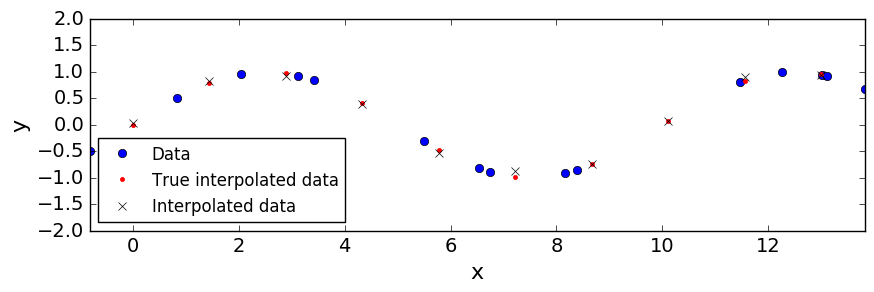

In [14]:
plt.figure(figsize=(10,10))
plt.axis('scaled')
plt.plot(x, y, 'bo', label='Data')
plt.plot(x0, y0, 'r.', label='True interpolated data')
plt.plot(x0, y0_calc, 'xk', label='Interpolated data')
plt.xlim(np.min([np.min(x0),np.min(x)]), np.max([np.max(x0),np.max(x)]))
plt.ylim(-2., 2.)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', numpoints=1, fontsize=12)
plt.show()

### Exercise 25

The folder `synthetic_gravity_data` contains a jupyter notebook named [`synthetic_data_fatiando.ipynb`](https://nbviewer.jupyter.org/github/birocoles/Disciplina-metodos-computacionais/blob/master/Content/synthetic_gravity_data/synthetic_data_fatiando.ipynb). This code uses the open-source Python toolkit for geophysical modeling and inversion [Fatiando a Terra](http://www.fatiando.org/) for calculating the gravity anomaly produced by the following synthetic body:

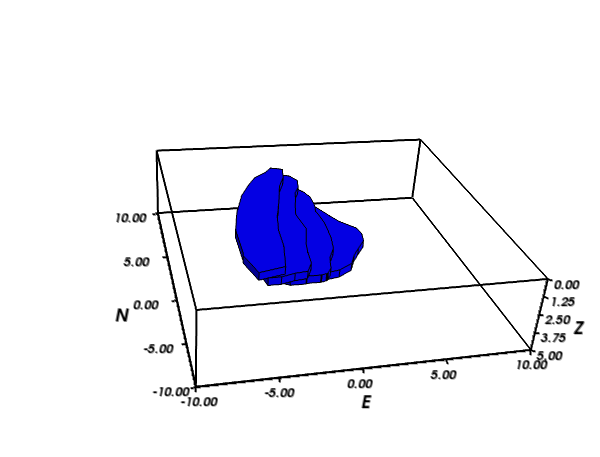

In [15]:
img('synthetic_gravity_data/model.png')

The synthetic body shown above produces the gravity anomaly shown below:

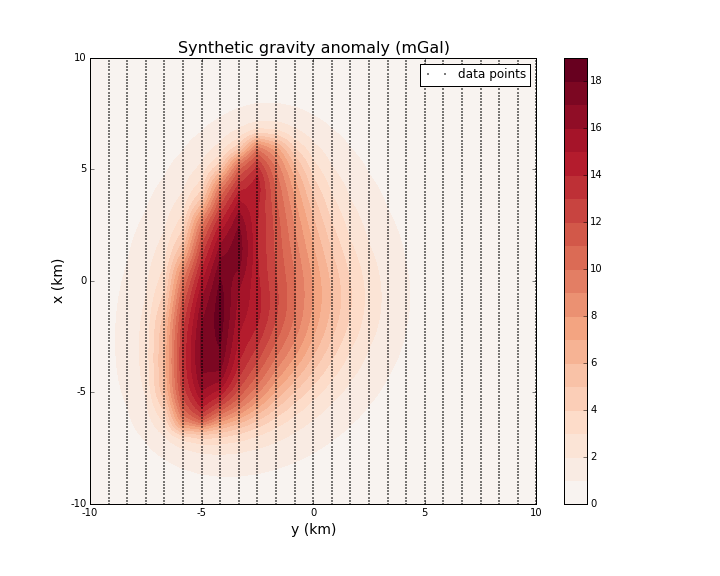

In [16]:
img('synthetic_gravity_data/map.png')

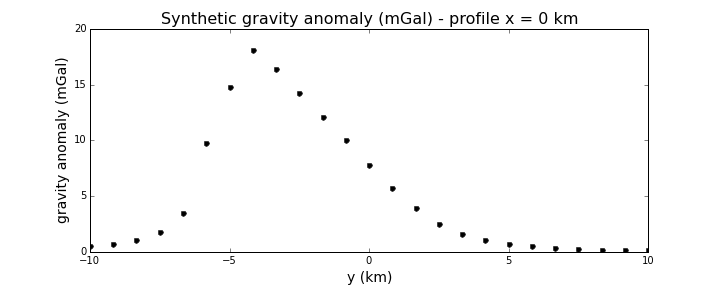

In [17]:
img('synthetic_gravity_data/profile.png')

The files `synthetic_gravity_data/gravity_anomaly.txt` and `synthetic_gravity_data/gravity_anomaly_profile.txt` contain, respectively, the synthetic gravity anomaly map and the gravity anomaly profile on x = 0 m.

To solve this exercise:

1. Load the file `synthetic_gravity_data/gravity_anomaly_profile.txt` by using the routine [`numpy.loadtxt`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html). 

2. Use the functions `spline3` and `spline3_interpolate` to calculate one interpolated gravity data between two adjacent gravity data (black dots on the gravity profile) on the profile.

3. Plot a Figure similar to the gravity profile shown above containing: (i) the original data (black dots on the gravity profile) and (ii) the interpolated points.

4. Use the calculated splines and plot the first derivative of the gravity data along the profile, at the coordinates of the original data.